In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_data = np.loadtxt('data/X.txt')
y_data = np.loadtxt('data/y.txt')

X_data, y_data = shuffle(X_data, y_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=800)

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

def plot_classes(X, y, filename=None):
    figure = plt.figure()
    class0 = y == 0
    class1 = y == 1
    plt.plot(X[class0, 0], X[class0, 1], 'ro', markersize=3, label='Class 0')
    plt.plot(X[class1, 0], X[class1, 1], 'bo', markersize=3, label='Class 1')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend(loc='upper left')
    if filename:
        plt.savefig(filename)
    return figure

#plot_classes(X_data, y_data, "plots/data.png")
#plt.show()

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def prepend_ones(M):
    return np.column_stack((np.ones(M.shape[0]), M))

In [5]:
def expand_rbf(l, X, Z=X_train):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return prepend_ones(np.exp(-0.5 / l**2 * r2))

In [6]:
def log_prior(w, variance):
    return -1 / (2 * variance) * (w.T @ w)

In [7]:
def log_likelihood(w, X, y):
    sigma = logistic(X @ w)
    return np.sum(y * np.log(sigma)
                  + (1 - y) * np.log(1 - sigma))

def negative_log_likelihood(w, X, y):
    return -log_likelihood(w, X, y)

def log_likelihood_gradient(w, X, y):
    return (y - logistic(X @ w)) @ X

def negative_log_likelihood_gradient(w, X, y):
    return -log_likelihood_gradient(w, X, y)

In [8]:
def mean_log_likelihood(w, X, y):
    return log_likelihood(w, X, y) / y.size

In [9]:
def log_posterior(w, X, y, prior_variance):
    return log_likelihood(w, X, y) + log_prior(w, prior_variance)

def negative_log_posterior(w, X, y, prior_variance):
    return -log_posterior(w, X, y, prior_variance)

def posterior_gradient(w, X, y, prior_variance):
    return (y - logistic(X @ w)) @ X - w / prior_variance

def negative_posterior_gradient(w, X, y, prior_variance):
    return -posterior_gradient(w, X, y, prior_variance)

In [31]:
def evidence(w, X, y, rbf_width, prior_variance):
    X_tilde = expand_rbf(rbf_width, X_train)
    sigma = logistic(X_tilde @ w)
    C_N_inv = (np.identity(w.shape[0])/prior_variance
               + X_tilde @ X_tilde.T @ sigma @ (1-sigma))
    
    return (np.sqrt((2*pi)**(y.size/2) / np.linalg.det(C_N_inv)) 
            * np.exp(log_likelihood(w, X, y))
            * np.exp(log_prior(w, prior_variance)))

In [10]:
from scipy.optimize import fmin_l_bfgs_b as minimise

def find_w_map(X, y, w0=None, prior_variance=1):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1])
    w_map, posterior_at_wmap, d = minimise(negative_log_posterior,
                                           w0,
                                           negative_posterior_gradient,
                                           args=[X, y, prior_variance])
    return w_map
    
def find_w_ml(X, y, w0=None):
    if w0 is None:
        w0 = np.random.normal(size=X.shape[1])
    w_ml, likelihood_at_wml, d = minimise(negative_log_likelihood,
                                          w0,
                                          negative_log_likelihood_gradient,
                                          args=[X, y])
    return w_ml

In [11]:
def plot_predictive_distribution(inputs, labels, weights,
                                 predictive_function,
                                 rbf_width, 
                                 filename=None):
    plot_classes(inputs, labels)
    x_min, x_max = inputs[ :, 0 ].min() - .5, inputs[ :, 0 ].max() + .5
    y_min, y_max = inputs[ :, 1 ].min() - .5, inputs[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    expanded_grid = expand_rbf(rbf_width,
                               (np.concatenate((xx.ravel().reshape((-1, 1)),
                                                yy.ravel().reshape((-1, 1))), 1)))
    Z = predictive_function(expanded_grid, weights)
    Z = Z.reshape(xx.shape)
    contours = plt.contour(xx, yy, Z, cmap='RdBu', levels=10, linewidths=2)
    plt.clabel(contours, fontsize=10, fmt='%2.1f', colors='k')
    if filename:
        plt.savefig(filename)
    plt.show()

In [12]:
def confusion_matrix(weights, test_data, test_labels,
                     predictive_function,
                     rbf_width=0.1, prior_variance=1):
    class_probabilities = predictive_function(expand_rbf(rbf_width, test_data), weights)
    predicted_class1 = class_probabilities <= 0.5
    predicted_class2 = class_probabilities > 0.5
    correctly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 0)) / np.sum(test_labels == 0)
    incorrectly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 1)) / np.sum(test_labels == 1)
    correctly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 1)) / np.sum(test_labels == 1)
    incorrectly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 0)) / np.sum(test_labels == 0)

    print(f"[[{correctly_predicted_class1:.3f}, {incorrectly_predicted_class2:.3f}],\n"
          f" [{incorrectly_predicted_class1:.3f}, {correctly_predicted_class2:.3f}]]")

In [13]:
def direct_prediction(inputs, weights):
     return logistic(inputs @ weights)
    
def laplace_prediction(inputs, weights, rbf_width=0.1, prior_variance=1):
    X_tilde = expand_rbf(rbf_width, X_train)
    sigma = logistic(X_tilde @ weights)
    C_N = np.linalg.inv(np.identity(weights.shape[0])/prior_variance
                        + X_tilde @ X_tilde.T @ sigma @ (1-sigma))
    predictive_mean = inputs @ weights
    predictive_variance = np.array([x.T @ C_N @ x for x in inputs])
    return logistic(predictive_mean / np.sqrt(1 + predictive_variance*np.pi/8))
    

for rbf_width in [0.1, 1]:
    w_map = find_w_map(expand_rbf(rbf_width, X_train), y_train)

    plot_predictive_distribution(X_data, y_data, w_map,
                                 direct_prediction,
                                 rbf_width,
                                 filename=f"plots/predictive_distribution_MAP_width_{rbf_width}.png")
    print(f"Confusion matrix (MAP, rbf_width={rbf_width})")
    confusion_matrix(w_map, X_test, y_test,
                     direct_prediction,
                     rbf_width)
    
    plot_predictive_distribution(X_data, y_data, w_map,
                                 laplace_prediction,
                                 rbf_width,
                                 filename=f"plots/predictive_distribution_laplace_width_{rbf_width}.png")  
    print(f"Confusion matrix (Laplace, rbf_width={rbf_width})")
    confusion_matrix(w_map, X_test, y_test,
                 direct_prediction,
                 rbf_width)

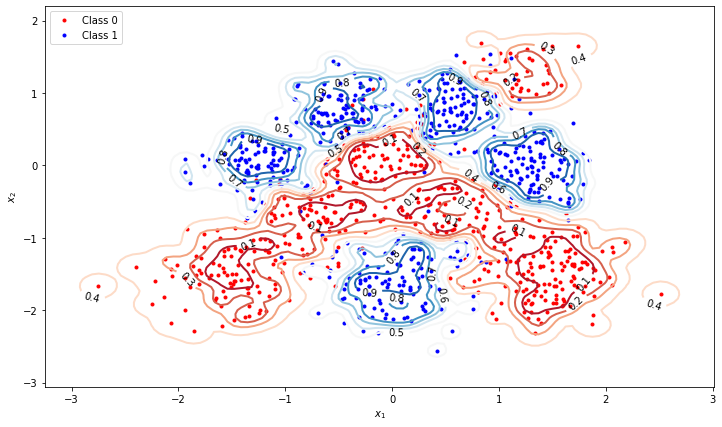

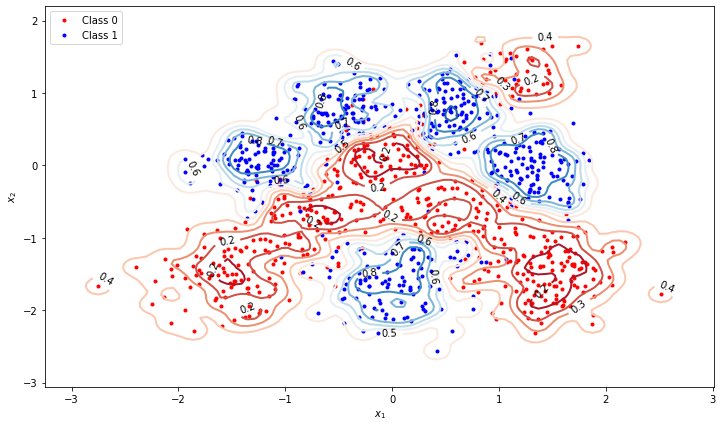

Confusion matrix (MAP prediction, test set, rbf_width=0.1)
[[0.917, 0.083],
 [0.165, 0.835]]
Confusion matrix (Laplace prediction, test set, rbf_width=0.1)
[[0.917, 0.083],
 [0.165, 0.835]]
Avg LL (MAP prediction, training set, rbf_width=0.1): -0.2157486544085461
Avg LL (MAP prediction, test set, rbf_width=0.1): -0.3181415291737455


/tmp/ipykernel_19486/1750037194.py:4: RuntimeWarning: divide by zero encountered in log
  + (1 - y) * np.log(1 - sigma))
/tmp/ipykernel_19486/1750037194.py:4: RuntimeWarning: invalid value encountered in multiply
  + (1 - y) * np.log(1 - sigma))
/tmp/ipykernel_19486/3743801831.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_19486/1750037194.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum(y * np.log(sigma)
/tmp/ipykernel_19486/1750037194.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum(y * np.log(sigma)


Confusion matrix (ML prediction, test set, rbf_width=0.1)
[[0.899, 0.101],
 [0.264, 0.736]]
Avg LL (ML prediction, training set, rbf_width=0.1): nan
Avg LL (ML prediction, test set, rbf_width=0.1): nan


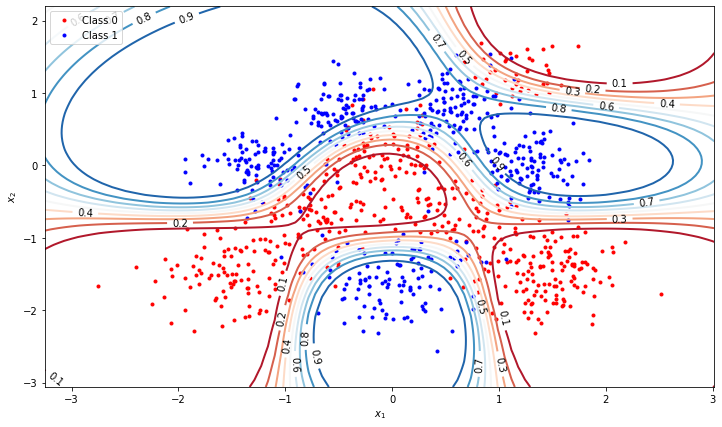

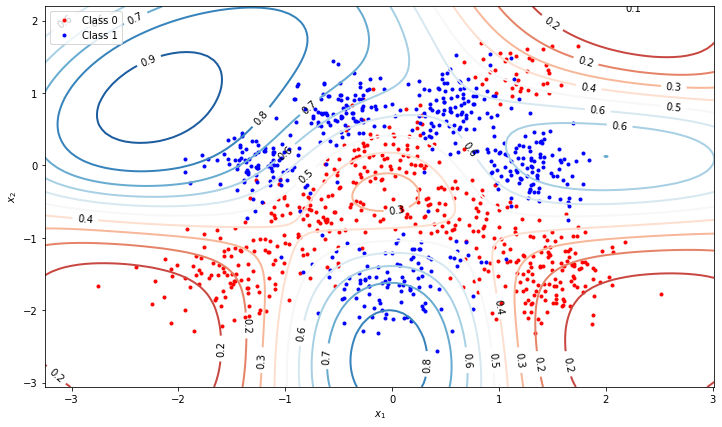

Confusion matrix (MAP prediction, test set, rbf_width=1)
[[0.954, 0.046],
 [0.077, 0.923]]
Confusion matrix (Laplace prediction, test set, rbf_width=1)
[[0.954, 0.046],
 [0.077, 0.923]]
Avg LL (MAP prediction, training set, rbf_width=1): -0.2168957625615
Avg LL (MAP prediction, test set, rbf_width=1): -0.2038696977700225
Confusion matrix (ML prediction, test set, rbf_width=1)
[[0.945, 0.055],
 [0.077, 0.923]]
Avg LL (ML prediction, training set, rbf_width=1): -0.16905185001852685
Avg LL (ML prediction, test set, rbf_width=1): -0.2114344830590602


In [15]:
for rbf_width in [0.1, 1]:
    expanded_training_set = expand_rbf(rbf_width, X_train)
    expanded_test_set = expand_rbf(rbf_width, X_test)
    
    w_map = find_w_map(expanded_training_set, y_train)

    plot_predictive_distribution(X_data, y_data, w_map,
                                 direct_prediction,
                                 rbf_width,
                                 filename=f"plots/predictive_distribution_MAP_width_{rbf_width}.png")
    plot_predictive_distribution(X_data, y_data, w_map,
                                 laplace_prediction,
                                 rbf_width,
                                 filename=f"plots/predictive_distribution_laplace_width_{rbf_width}.png")  
    
    print(f"Confusion matrix (MAP prediction, test set, rbf_width={rbf_width})")
    confusion_matrix(w_map, X_test, y_test,
                     direct_prediction,
                     rbf_width)
    print(f"Confusion matrix (Laplace prediction, test set, rbf_width={rbf_width})")
    confusion_matrix(w_map, X_test, y_test,
                     laplace_prediction,
                     rbf_width)
    print(f"Avg LL (MAP prediction, training set, rbf_width={rbf_width}): " 
          f"{mean_log_likelihood(w_map, expanded_training_set, y_train)}")
    print(f"Avg LL (MAP prediction, test set, rbf_width={rbf_width}): " 
          f"{mean_log_likelihood(w_map, expanded_test_set, y_test)}")
          
    
    w_ml = find_w_ml(expanded_training_set, y_train)
          
    print(f"Confusion matrix (ML prediction, test set, rbf_width={rbf_width})")        
    confusion_matrix(w_ml, X_test, y_test,
                     direct_prediction,
                     rbf_width)
    print(f"Avg LL (ML prediction, training set, rbf_width={rbf_width}): " 
          f"{mean_log_likelihood(w_ml, expanded_training_set, y_train)}")
    print(f"Avg LL (ML prediction, test set, rbf_width={rbf_width}): "
          f"{mean_log_likelihood(w_ml, expanded_test_set, y_test)}")

In [32]:
rbf_widths = np.linspace(0.1, 1, 10)
prior_variances = np.array([0.01, 0.1, 0.5, 0.75, 1, 1.25, 1.5, 2, 5, 10])

for width in rbf_widths:
    for variance in prior_variances:

    expanded_training_set = expand_rbf(rbf_width, X_train)    
    w_map = find_w_map(expanded_training_set, y_train)
    return evidence(w_map, X_train, y_train, width, variance)

evidence_grid(xx, yy)

ValueError: operands could not be broadcast together with shapes (10,10) (800,800) 

In [29]:
?np.linalg.det
